In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as opt
import statsmodels.api as sm
df = pd.read_csv('../data/20190606180000-20190606190000.csv')
df=df.replace([np.inf, -np.inf], np.nan)
df=df.dropna();

C:\Users\Rachael\.conda\envs\py3tf1gnt\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (77,79,81,83,85,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
horizon = 61; # horizon of TLG..61.-- sec
cycle   = 15; # 15Hz sampling -- 1 sec
supercycle = cycle*horizon;

In [2]:
df=df.round(decimals=5)  # round to one decimal after precision of devices
df['diff'] = (df['B_VIMIN'] - df['B:VIMIN'])
df2= pd.DataFrame({'diff' : df['diff'], 'err' : df['B:IMINER']})

In [3]:
df2.head()

,diff,err
0,0.00665,0.07469
1,0.00104,0.01469
2,-0.00702,-0.07031
3,-0.00241,-0.02031
4,-0.00304,-0.02031


In [4]:
df2.drop(df2[df2['diff'] == 0].index, inplace=True)

sample_size = 4500;
train = df2.sample(n = sample_size, random_state = 42)
train.head()

,diff,err
15799,0.02188,0.09469
30041,-0.02069,0.12469
18673,-0.00498,-0.04531
32461,-0.02418,-0.08031
31338,-0.00314,0.11969


In [5]:
x = train['err']
y = train['diff']
A = np.vstack([x, np.ones(len(x))]).T

In [6]:
# regress: y = mx + b
# rewrite: y = [x, 1]^T [m,b] 
#            = A^t [m,b]
#  ==> [m,b] = inv(A A^t)Ay
# or solve for [m, b] using np
m, b = np.linalg.lstsq(A, y, rcond = None)[0] # return slope m and bias b

# calculate R^2 value to get an idea of fit
ssres = sum(y- (m*x + b))**2;
sstot = sum(y-np.mean(y))**2;
rsq = 1.0 - (ssres/sstot)

# print results
rs_str = 'R^2 value: ' + str(rsq)
print('scaling factor: ' , m,'; bias: ', b)
print(rs_str)
print('min diff: ' , min(abs(y)),'; max diff: ', max(abs(y)))

scaling factor:  0.05504009742602691 ; bias:  -0.0020481607438263315
R^2 value: 0.9961988365974968
min diff:  1.0000000003174137e-05 ; max diff:  0.70411


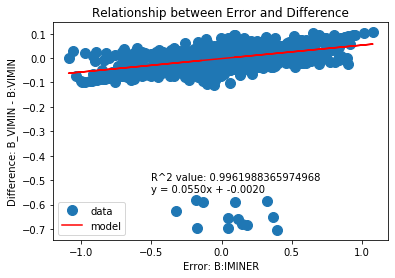

In [7]:
# plot results
plt.plot(x, y, 'o', label='data', markersize=10)
plt.plot(x, m*x + b, 'r', label='model')
plt.text(-0.5,-0.5, rs_str)
str_desc = 'y = ' + str('%.4f'%m) + 'x + '+ str('%.4f'%b);
plt.text(-0.5,-0.55, str_desc)
plt.title('Relationship between Error and Difference')
plt.xlabel('Error: B:IMINER')
plt.ylabel('Difference: B_VIMIN - B:VIMIN')
plt.legend()
plt.show()

Now we play with the same data but consider a coupling in time of the data.
We assume the difference in 'err' and 'diff' is offset by one time step.

In [8]:
df3 = pd.DataFrame({'diff': df['B_VIMIN'][0:-2] - df['B:VIMIN'][0:-2], 'err' : df['B:IMINER'][1:-1]})
df3.drop(df2[df2['diff'] == 0].index, inplace=True)
train2 = df3.sample(n = sample_size, random_state = 42)
train2.head()
x2 = train['err']
y2 = train['diff']
A2 = np.vstack([x2, np.ones(len(x2))]).T

In [9]:
# regress: y = mx + b
# rewrite: y = [x, 1]^T [m,b] 
#            = A^t [m,b]
#  ==> [m,b] = inv(A A^t)Ay
# or solve for [m, b] using np
m2, b2 = np.linalg.lstsq(A2, y2, rcond = None)[0] # return slope m and bias b

# calculate R^2 value to get an idea of fit
ssres2 = sum(y2- (m2*x2 + b2))**2;
sstot2 = sum(y2-np.mean(y2))**2;
rsq2 = 1.0 - (ssres2/sstot2)

# print results
rs_str2 = 'R^2 value: ' + str(rsq2)
print('scaling factor: ' , m2,'; bias: ', b2)
print(rs_str2)
print('min diff: ' , min(abs(y2)),'; max diff: ', max(abs(y2)))

scaling factor:  0.05504009742602691 ; bias:  -0.0020481607438263315
R^2 value: 0.9961988365974968
min diff:  1.0000000003174137e-05 ; max diff:  0.70411


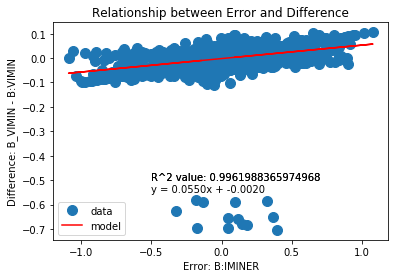

In [10]:
plt.plot(x2, y2, 'o', label='data', markersize=10)
plt.plot(x2, m2*x2 + b2, 'r', label='model')
plt.text(-0.5,-0.5, rs_str)
str_desc2 = 'y = ' + str('%.4f'%m2) + 'x + '+ str('%.4f'%b2);
plt.text(-0.5,-0.55, str_desc2)
plt.title('Relationship between Error and Difference')
plt.xlabel('Error: B:IMINER')
plt.ylabel('Difference: B_VIMIN - B:VIMIN')
plt.text(-0.5,-0.5, rs_str2)
plt.legend()
plt.show()

In [11]:
# by hand approach to estimating coeff
sx   = np.sum(x)
sy   = np.sum(y)
sx2 = np.sum(x**2)
sy2 = np.sum(y**2)
sxy  = np.dot(x,y)
n= float(len(x));
mhat = (n*sxy - sx*sy)/(n*sx2 - sx**2)
bhat = (1.0/n)*sy - mhat/n*sx
sig_ep2   = (1.0/(n*(n-2)))*(n*sy2 - sy**2 - (mhat**2)*(n*sx2 - sx**2))
sig_mhat2 = n*sig_ep2/(n*sx2-sx**2)
sig_bhat2 = sig_mhat2/n*(sx2)

In [12]:
# t-test vals for n=998 points, from simulation-math.com/TDistTable.pdf:
# 998 0.675 0.842 1.037 1.282 1.646 1.962 2.056 2.330 2.581 2.813  3.098 3.300
# DOF 0.25   0.2   0.15  0.1   0.05 0.025 0.02  0.01  0.005 0.0025 0.001 0.0005
conf_mult = 1.646
bhat_upper = bhat + conf_mult *np.sqrt(sig_bhat2)
bhat_lower = bhat - conf_mult *np.sqrt(sig_bhat2)
mhat_upper = mhat + conf_mult *np.sqrt(sig_mhat2)
mhat_lower = mhat - conf_mult *np.sqrt(sig_mhat2)
mhat_conf = conf_mult *np.sqrt(sig_mhat2)
print('coefficient 95-degree of confidence is %0.4f'%mhat, '+- %0.4f'%mhat_conf)
print('i.e. confidence interval at 95-level: (%0.4f,'%mhat_lower, '%0.4f) '%mhat_upper)

coefficient 95-degree of confidence is 0.0550 +- 0.0041
i.e. confidence interval at 95-level: (0.0509, 0.0592) 


In [13]:
conf_mult2 = 3.098
bhat_upper2 = bhat + conf_mult2 *np.sqrt(sig_bhat2)
bhat_lower2 = bhat - conf_mult2 *np.sqrt(sig_bhat2)
mhat_upper2 = mhat + conf_mult2 *np.sqrt(sig_mhat2)
mhat_lower2 = mhat - conf_mult2 *np.sqrt(sig_mhat2)
mhat_conf2 = conf_mult *np.sqrt(sig_mhat2)
print('coefficient 99.9-degree of confidence is %0.4f'%mhat, '+- %0.4f'%mhat_conf2)
print('i.e. confidence interval at 95-level: (%0.4f,'%mhat_lower2, '%0.4f) '%mhat_upper2)

coefficient 99.9-degree of confidence is 0.0550 +- 0.0041
i.e. confidence interval at 95-level: (0.0473, 0.0628) 


Text(0.5, 1.0, 'B_VIMIN')

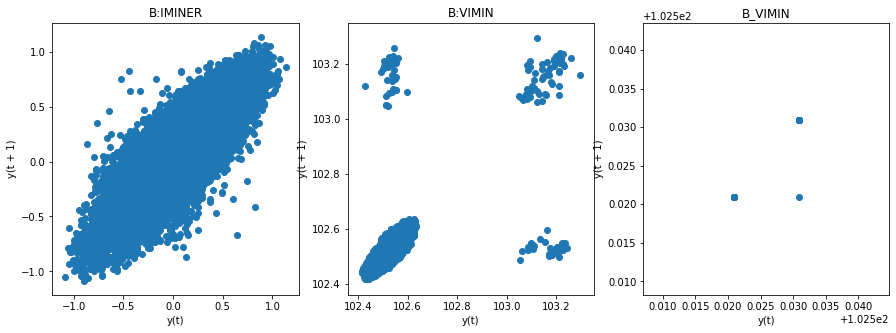

In [14]:

f2, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
col1,col2,col3='B:IMINER','B:VIMIN','B_VIMIN'

lag_plot(df[col1],ax=ax1)
ax1.set_title(col1)
lag_plot(df[col2],ax=ax2)
ax2.set_title(col2)
lag_plot(df[col3],ax=ax3)
ax3.set_title(col3)

Note the structure in both B:IMINER and B:VIMIN. The linear dependence of time in B:IMINER makes sense, as it is a function of input from the time step before and the current time. B:VIMIN is a little more interesting; B_VIMIN should actually be constant, so to see different data points is also interesting. 

The linearity of the data ofo B:IMINER (and clusters of B:VIMIN) suggests that we should use an auto-regressive model for the data.

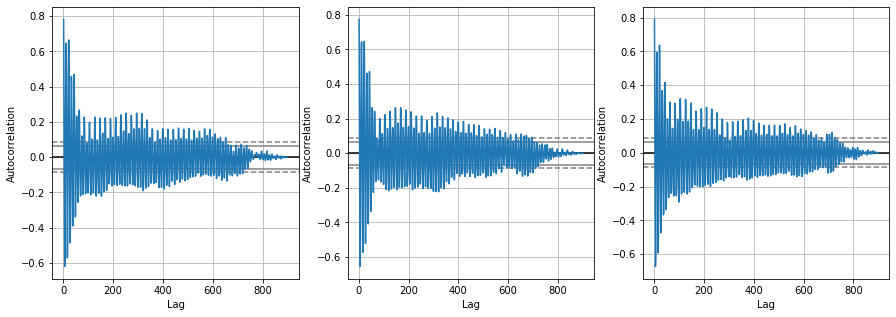

In [30]:
from pandas.plotting import autocorrelation_plot
lam = supercycle
t0  = 0
f3, (ax4,ax5,ax6) = plt.subplots(1,3,figsize=(15,5))
autocorrelation_plot(df[col1].iloc[t0:t0+lam],ax4)
autocorrelation_plot(df[col1].iloc[t0+lam:t0+lam*2],ax5)
autocorrelation_plot(df[col1].iloc[t0+2*lam:t0+lam*3],ax6)

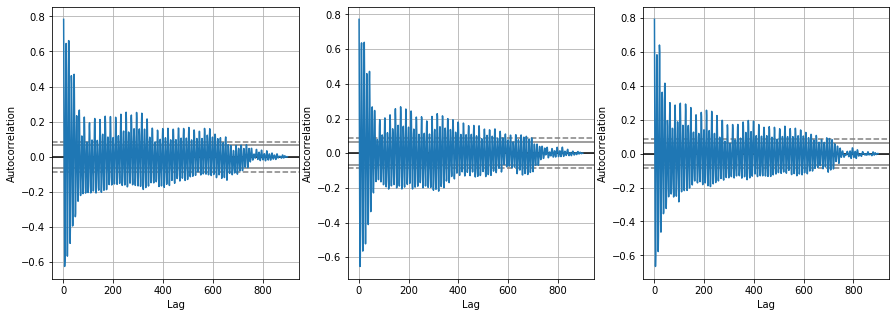

In [31]:
from pandas.plotting import autocorrelation_plot
t0  = cycle
f3, (ax4,ax5,ax6) = plt.subplots(1,3,figsize=(15,5))
autocorrelation_plot(df[col1].iloc[t0:t0+lam],ax4)
autocorrelation_plot(df[col1].iloc[t0+lam:t0+lam*2],ax5)
autocorrelation_plot(df[col1].iloc[t0+2*lam:t0+lam*3],ax6)

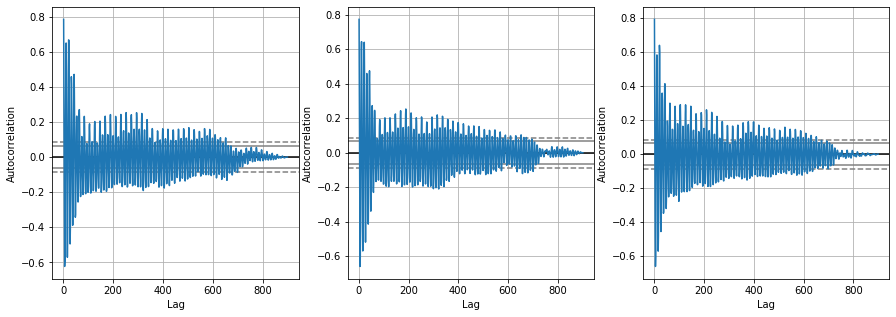

In [32]:
from pandas.plotting import autocorrelation_plot
t0  = 2*cycle
f3, (ax4,ax5,ax6) = plt.subplots(1,3,figsize=(15,5))
autocorrelation_plot(df[col1].iloc[t0:t0+lam],ax4)
autocorrelation_plot(df[col1].iloc[t0+lam:t0+lam*2],ax5)
autocorrelation_plot(df[col1].iloc[t0+2*lam:t0+lam*3],ax6)

In [ ]:
from pandas.plotting import autocorrelation_plot
lam = 900
t0  = 0
f3, (ax4,ax5,ax6) = plt.subplots(1,3,figsize=(15,5))
autocorrelation_plot(df[col1].iloc[t0:t0+lam],ax4)
autocorrelation_plot(df[col1].iloc[t0+lam:t0+lam*2],ax5)
autocorrelation_plot(df[col1].iloc[t0+2*lam:t0+lam*3],ax6)